1. retrieve
2. generate
3. rewrite  <- 신규 node
4. 문서 검증 <- 신규 node

In [1]:
# chroma db 접근
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection"
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [2]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

graph_builder = StateGraph(AgentState)

In [3]:
def retrieve(state: AgentState):
    query = state["query"]
    docs = retrieve.invoke(query)
    return {"context": docs}

In [4]:
from langsmith import Client
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [5]:
# 프롬프트 불러오기 (generate_prompt 변수에 저장)
client = Client()
generate_prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)

def generate(state: AgentState):
    context = state["context"]
    query = state["query"]
    rag_chain = generate_prompt | llm
    response = rag_chain.invoke({"context": context, "question": query})
    return {"answer": response}

In [6]:
from typing import Literal

# 문서 관련성 평가 프롬프트 불러오기 (doc_relevance_prompt 변수에 저장)
client = Client()
doc_relevance_prompt = client.pull_prompt("langchain-ai/rag-document-relevance", include_model=True)

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    query = state["query"]
    context = state['context']
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'questions': query, 'documents': context})
    if response['Score'] == 1:
        return 'generate'

    return 'rewrite'

In [7]:
query = '연봉 5천만원 직장인의 소득세는?'

In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
dictionary = ['사람과 관련된 표현자 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
사전 : {dictionary}
질문 : {query} 
""")

def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({'query': query})
    return {'query': response}

In [9]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

In [10]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)


In [11]:
graph = graph_builder.compile()

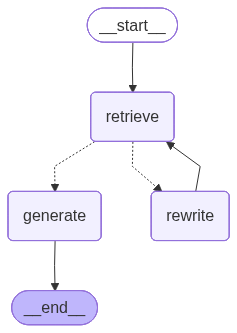

In [12]:
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [ ]:
initial_state = {'query' : '연봉 5천만원 세금'}
graph.invoke(initial_state)